# Calibration of epidemiological parameters

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from os.path import join
from scipy.optimize import root_scalar
from math import gamma

# parallelisation functionality
from multiprocess import Pool
import psutil
from tqdm import tqdm

In [2]:
def weibull_two_param(shape, scale):
    '''
    A two-parameter Weibull distribution, based on numpy ramdon's single 
    parameter distribution. We use this distribution in the simulation to draw
    random epidemiological parameters for agents from the given distribution
    See https://numpy.org/doc/stable/reference/random/generated/numpy.random.weibull.html
    '''
    return scale * np.random.weibull(shape)


def get_weibull_shape(k, mu, var):
    '''
    Calculates the shape parameter of a Weibull distribution, given its mean
    mu and its variance var
    '''
    return var / mu**2 - gamma(1 + 2/k) / gamma(1+1/k)**2 + 1



def get_weibull_scale(mu, k):
    '''
    Calculates the scale parameter of a Weibull distribution, given its mean
    mu and its shape parameter k
    '''
    return mu / gamma(1 + 1/k)


In [3]:
def get_true_epi_params(p):
    e, t, i, e_std, t_std, i_std = p
    curr_epi_params = {
        "exposure_duration":{"mean":e, "std":e_std},
        "time_until_symptoms":{"mean":t, "std":t_std},
        "infection_duration":{"mean":i, "std":i_std}
    }
    for param_name in curr_epi_params.keys():
        mu = curr_epi_params[param_name]["mean"]
        var = curr_epi_params[param_name]["std"]**2
        shape = root_scalar(get_weibull_shape, args=(mu, var),
                    method='toms748', bracket=[0.2, 500]).root
        scale = get_weibull_scale(mu, shape)
        curr_epi_params[param_name]["shape"] = shape
        curr_epi_params[param_name]["scale"] = scale
    
    exposure_duration = []
    time_until_symptoms = []
    infection_duration = []
    for i in range(1000):
        tmp_epi_params = {}
        while True:
            for param_name in curr_epi_params.keys():
                tmp_epi_params[param_name] = \
                    round(weibull_two_param(curr_epi_params[param_name]["shape"],
                                            curr_epi_params[param_name]["scale"]))

            if (tmp_epi_params['exposure_duration'] >= 1) and \
               (tmp_epi_params['time_until_symptoms'] >= \
               tmp_epi_params['exposure_duration']) and\
               (tmp_epi_params['infection_duration'] >= \
               tmp_epi_params['time_until_symptoms']):
               break

        exposure_duration.append(tmp_epi_params['exposure_duration'])
        time_until_symptoms.append(tmp_epi_params['time_until_symptoms'])
        infection_duration.append(tmp_epi_params['infection_duration'])

    exposure_duration = np.asarray(exposure_duration)
    time_until_symptoms = np.asarray(time_until_symptoms)
    infection_duration = np.asarray(infection_duration)
    
    row = {
        'e_mean':curr_epi_params["exposure_duration"]["mean"],
        'e_std':curr_epi_params["exposure_duration"]["std"],
        't_mean':curr_epi_params["time_until_symptoms"]["mean"],
        't_std':curr_epi_params["time_until_symptoms"]["std"],
        'i_mean':curr_epi_params["infection_duration"]["mean"],
        'i_std':curr_epi_params["infection_duration"]["std"],
        'true_e_mean':exposure_duration.mean(),
        'true_e_std':exposure_duration.std(),
        'true_t_mean':time_until_symptoms.mean(),
        'true_t_std':time_until_symptoms.std(),
        'true_i_mean':infection_duration.mean(),
        'true_i_std':infection_duration.std()
    }
    return row

## Wild type

In [4]:
expected_epi_params = {
    "exposure_duration":{"mean":5.0, "std":1.9},
    "time_until_symptoms":{"mean":6.4, "std":0.8},
    "infection_duration":{"mean":10.91, "std":3.95}
}

### Coarse grid search

In [5]:
step = 0.2
exposure_durations = np.arange(4, 6 + step, step)
times_until_symtoms = np.arange(5.6, 8 + step, step)
infection_durations = np.arange(9, 11 + step, step)

step = 0.25
exposure_duration_stds = np.arange(1.5, 2.4 + step, step)
times_until_symtoms_stds = np.arange(0.2, 1.4 + step, step)
infection_durations_stds = np.arange(3, 5 + step * 2, step * 2)

param_combinations = [(e, t, i, e_std, t_std, i_std) \
                                for e in exposure_durations \
                                for t in times_until_symtoms \
                                for i in infection_durations \
                                for e_std in exposure_duration_stds \
                                for t_std in times_until_symtoms_stds \
                                for i_std in infection_durations_stds]
print(f"{len(param_combinations)} parameter combinations")

235950 parameter combinations


In [ ]:
results = pd.DataFrame()

pool = Pool(200)
for row in tqdm(
        pool.imap_unordered(
            func=get_true_epi_params, 
            iterable=param_combinations),
            total=len(param_combinations)
    ):
    results = results.append(row, ignore_index=True)
pool.close()

results["e_mean_diff"] = results["true_e_mean"]\
    .apply(lambda x: (x - expected_epi_params["exposure_duration"]["mean"]) ** 2)
results["e_std_diff"] = results["true_e_std"]\
    .apply(lambda x: (x - expected_epi_params["exposure_duration"]["std"]) ** 2)
results["t_mean_diff"] = results["true_t_mean"]\
    .apply(lambda x: (x - expected_epi_params["time_until_symptoms"]["mean"]) ** 2)
results["t_std_diff"] = results["true_t_std"]\
    .apply(lambda x: (x - expected_epi_params["time_until_symptoms"]["std"]) ** 2)
results["i_mean_diff"] = results["true_i_mean"]\
    .apply(lambda x: (x - expected_epi_params["infection_duration"]["mean"]) ** 2)
results["i_std_diff"] = results["true_i_std"]\
    .apply(lambda x: (x - expected_epi_params["infection_duration"]["std"]) ** 2)

results["mean_diff"] = results["e_mean_diff"] + results["t_mean_diff"] + results["i_mean_diff"]
results["std_diff"] = results["e_std_diff"] + results["t_std_diff"] + results["i_std_diff"]
results["diff"] = results["mean_diff"] + results["std_diff"]

results.to_csv("results_coarse_wt.csv", index=False)

 69%|█████████████████████████████████████████                   | 161705/235950 [14:46<04:17, 287.82it/s]

In [6]:
results = pd.read_csv("results_coarse_wt.csv")

In [7]:
exposure_durations = [round(e, 2) for e in exposure_durations]
times_until_symtoms = [round(t, 2) for t in times_until_symtoms]

round_cols = ["e_mean", "e_std", "t_mean", "t_std", "i_mean", "i_std"]
for col in round_cols:
    results[col] = results[col].apply(lambda x: round(x, 2))
    
img = np.zeros((len(exposure_durations), len(times_until_symtoms)))

results = results.set_index(["e_mean", "t_mean", "i_mean", "e_std", "t_std", "i_std"])
for i, e in enumerate(exposure_durations):
    for j, t in enumerate(times_until_symtoms):
        img[i, j] = results.loc[e, t, 10, 2.5, 2.25, 4]["diff"]
results = results.reset_index()

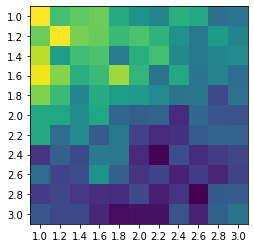

In [8]:
fig, ax = plt.subplots()
ax.imshow(img)
ax.set_yticks(range(len(exposure_durations)))
ax.set_yticklabels(exposure_durations)
ax.set_xticks(range(len(times_until_symtoms)))
ax.set_xticklabels(times_until_symtoms);

In [9]:
idx_best = results["diff"].idxmin()
best_e_mean = results.loc[idx_best, "e_mean"]
best_e_std = results.loc[idx_best, "e_std"]
best_t_mean = results.loc[idx_best, "t_mean"]
best_t_std = results.loc[idx_best, "t_std"]
best_i_mean = results.loc[idx_best, "i_mean"]
best_i_std = results.loc[idx_best, "i_std"]

print(f"best e: [{best_e_mean, best_e_std}]")
print(f"best t: [{best_t_mean, best_t_std}]")
print(f"best i: [{best_i_mean, best_i_std}]")

best e: [(3.0, 2.5)]
best t: [(2.2, 2.0)]
best i: [(10.6, 4.0)]


In [10]:
results[results["diff"] < 0.6]

,e_mean,t_mean,i_mean,e_std,t_std,i_std,true_e_mean,true_e_std,true_t_mean,true_t_std,...,true_i_std,e_mean_diff,e_std_diff,t_mean_diff,t_std_diff,i_mean_diff,i_std_diff,mean_diff,std_diff,diff
153821,3.0,1.2,10.8,2.25,2.00,4.0,1.844,1.244855,3.039,2.235951,...,3.821115,0.024336,0.429215,0.001521,0.112863,0.006561,0.016611,0.032418,0.558690,0.591108
156614,3.0,1.6,10.8,2.50,2.00,4.0,1.805,1.189527,2.992,2.073629,...,3.874239,0.038025,0.504772,0.000064,0.030147,0.007056,0.005740,0.045145,0.540658,0.585803
157967,3.0,1.8,10.8,2.25,2.00,4.0,1.862,1.199565,3.181,2.085723,...,3.974665,0.019044,0.490609,0.032761,0.034493,0.000361,0.000608,0.052166,0.525711,0.577877
160608,3.0,2.2,10.6,2.50,2.00,4.0,1.921,1.234811,3.247,1.931836,...,3.768070,0.006241,0.442476,0.061009,0.001014,0.004489,0.033099,0.071739,0.476588,0.548327
160699,3.0,2.2,10.8,2.25,1.75,4.0,1.898,1.196493,3.197,1.791142,...,3.898593,0.010404,0.494922,0.038809,0.011850,0.000729,0.002643,0.049942,0.509414,0.559356


### Fine grid search

In [22]:
step = 0.05
window = 0.25
exposure_durations = np.arange(best_e_mean - window, best_e_mean + window + step, step)
times_until_symtoms = np.arange(best_t_mean - window, best_t_mean + window + step, step)
infection_durations = np.arange(best_i_mean - window, best_i_mean + window + step, step)

step = 0.1
exposure_duration_stds = np.arange(best_e_std - window, best_e_std + window + step, step)
times_until_symtoms_stds = np.arange(best_t_std - window, best_t_std + window + step, step)
infection_durations_stds = np.arange(best_i_std - window, best_i_std + window + step, step)

param_combinations = [(e, t, i, e_std, t_std, i_std) \
                                for e in exposure_durations \
                                for t in times_until_symtoms \
                                for i in infection_durations \
                                for e_std in exposure_duration_stds \
                                for t_std in times_until_symtoms_stds \
                                for i_std in infection_durations_stds]
print(f"{len(param_combinations)} parameter combinations")

426888 parameter combinations


In [12]:
results_fine = pd.DataFrame()

pool = Pool(200)
for row in tqdm(
        pool.imap_unordered(
            func=get_true_epi_params, 
            iterable=param_combinations),
            total=len(param_combinations)
    ):
    results_fine = results_fine.append(row, ignore_index=True)
pool.close()

100%|███████████████████████████████████████████████████████████████████████████| 426888/426888 [41:06<00:00, 173.04it/s]


In [14]:
results_fine["e_mean_diff"] = results_fine["true_e_mean"]\
    .apply(lambda x: (x - expected_epi_params["exposure_duration"]["mean"]) ** 2)
results_fine["e_std_diff"] = results_fine["true_e_std"]\
    .apply(lambda x: (x - expected_epi_params["exposure_duration"]["std"]) ** 2)
results_fine["t_mean_diff"] = results_fine["true_t_mean"]\
    .apply(lambda x: (x - expected_epi_params["time_until_symptoms"]["mean"]) ** 2)
results_fine["t_std_diff"] = results_fine["true_t_std"]\
    .apply(lambda x: (x - expected_epi_params["time_until_symptoms"]["std"]) ** 2)
results_fine["i_mean_diff"] = results_fine["true_i_mean"]\
    .apply(lambda x: (x - expected_epi_params["infection_duration"]["mean"]) ** 2)
results_fine["i_std_diff"] = results_fine["true_i_std"]\
    .apply(lambda x: (x - expected_epi_params["infection_duration"]["std"]) ** 2)

results_fine["mean_diff"] = results_fine["e_mean_diff"] + results_fine["t_mean_diff"] + results_fine["i_mean_diff"]
results_fine["std_diff"] = results_fine["e_std_diff"] + results_fine["t_std_diff"] + results_fine["i_std_diff"]
results_fine["diff"] = results_fine["mean_diff"] + results_fine["std_diff"]

results_fine.to_csv("results_fine_wt.csv", index=False)

In [ ]:
results_fine = pd.read_csv("results_fine_wt.csv")

In [40]:
exposure_durations = [round(e, 3) for e in exposure_durations]
times_until_symtoms = [round(t, 3) for t in times_until_symtoms]

round_cols = ["e_mean", "e_std", "t_mean", "t_std", "i_mean", "i_std"]
for col in round_cols:
    results_fine[col] = results_fine[col].apply(lambda x: round(x, 3))
    
img = np.zeros((len(exposure_durations), len(times_until_symtoms)))

results_fine = results_fine.set_index(["e_mean", "t_mean", "i_mean", "e_std", "t_std", "i_std"])
for i, e in enumerate(exposure_durations):
    for j, t in enumerate(times_until_symtoms):
        img[i, j] = results_fine.loc[e, t, 10.6, 2.65, 1.85, 3.75]["diff"]
results_fine = results_fine.reset_index()

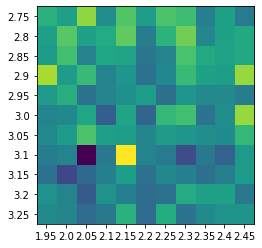

In [41]:
fig, ax = plt.subplots()
ax.imshow(img)
ax.set_yticks(range(len(exposure_durations)))
ax.set_yticklabels(exposure_durations)
ax.set_xticks(range(len(times_until_symtoms)))
ax.set_xticklabels(times_until_symtoms);

In [42]:
idx_best = results_fine["diff"].idxmin()
best_e_mean = results_fine.loc[idx_best, "e_mean"]
best_e_std = results_fine.loc[idx_best, "e_std"]
best_t_mean = results_fine.loc[idx_best, "t_mean"]
best_t_std = results_fine.loc[idx_best, "t_std"]
best_i_mean = results_fine.loc[idx_best, "i_mean"]
best_i_std = results_fine.loc[idx_best, "i_std"]

true_e_mean = results_fine.loc[idx_best, "true_e_mean"]
true_e_std = results_fine.loc[idx_best, "true_e_std"]
true_t_mean = results_fine.loc[idx_best, "true_t_mean"]
true_t_std = results_fine.loc[idx_best, "true_t_std"]
true_i_mean = results_fine.loc[idx_best, "true_i_mean"]
true_i_std = results_fine.loc[idx_best, "true_i_std"]

print(f"best e: [{best_e_mean, best_e_std}]")
print(f"best t: [{best_t_mean, best_t_std}]")
print(f"best i: [{best_i_mean, best_i_std}]")
print()
print(f"true e: [{true_e_mean, true_e_std}]")
print(f"true t: [{true_t_mean, true_t_std}]")
print(f"true i: [{true_i_mean, true_i_std}]")

best e: [(3.1, 2.65)]
best t: [(2.05, 1.85)]
best i: [(10.6, 3.75)]

true e: [(1.89, 1.2906974858579372)]
true t: [(3.147, 1.9691091894559836)]
true i: [(10.935, 3.754300867005733)]


### Epi parameter distribution plot

In [44]:
curr_epi_params = {
        "exposure_duration":{"mean":best_e_mean, "std":best_e_std},
        "time_until_symptoms":{"mean":best_t_mean, "std":best_t_std},
        "infection_duration":{"mean":best_i_mean, "std":best_i_std}
    }
for param_name in curr_epi_params.keys():
    mu = curr_epi_params[param_name]["mean"]
    var = curr_epi_params[param_name]["std"]**2
    shape = root_scalar(get_weibull_shape, args=(mu, var),
                method='toms748', bracket=[0.2, 500]).root
    scale = get_weibull_scale(mu, shape)
    curr_epi_params[param_name]["shape"] = shape
    curr_epi_params[param_name]["scale"] = scale

exposure_duration = []
time_until_symptoms = []
infection_duration = []
for i in range(10000):
    tmp_epi_params = {}
    while True:
        for param_name in curr_epi_params.keys():
            tmp_epi_params[param_name] = \
                round(weibull_two_param(curr_epi_params[param_name]["shape"],
                                        curr_epi_params[param_name]["scale"]))

        if (tmp_epi_params['exposure_duration'] >= 1) and \
           (tmp_epi_params['time_until_symptoms'] >= \
           tmp_epi_params['exposure_duration']) and\
           (tmp_epi_params['infection_duration'] >= \
           tmp_epi_params['time_until_symptoms']):
           break

    exposure_duration.append(tmp_epi_params['exposure_duration'])
    time_until_symptoms.append(tmp_epi_params['time_until_symptoms'])
    infection_duration.append(tmp_epi_params['infection_duration'])

exposure_duration = np.asarray(exposure_duration)
time_until_symptoms = np.asarray(time_until_symptoms)
infection_duration = np.asarray(infection_duration)

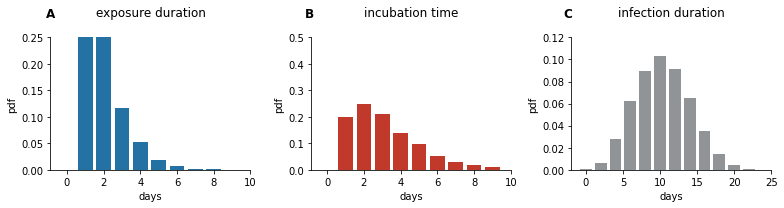

In [46]:
fig, axes = plt.subplots(1, 3, figsize=(11, 3))
fig.subplots_adjust(wspace=0.3)
max_bins = [11, 11, 26]
steps = [1, 1, 2]
colors = ['#2471A3', '#C0392B', '#909497']
xticks = [range(0, 11, 2), range(0, 11, 2), range(0, 26, 5)]
labels = ['exposure duration\n', 'incubation time\n', 'infection duration\n']
ymaxes = [0.25, 0.5, 0.12]

for ax, max_bin, step, color, xtick, label, ymax, param in zip(axes, max_bins, steps, colors,\
    xticks, labels, ymaxes, [exposure_duration, time_until_symptoms, infection_duration]):
    ax.hist(param, bins=range(0, max_bin, step), rwidth=0.8, color=color,
            density=True, align='left')
    ax.set_xticks(xtick)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title(label)
    ax.set_ylabel('pdf')
    ax.set_xlabel('days')
    ax.set_ylim(0, ymax)

fig.tight_layout()
fig.text(0.062, 0.9, 'A', fontsize=12, fontweight='bold')
fig.text(0.39, 0.9, 'B', fontsize=12, fontweight='bold')
fig.text(0.7162, 0.9, 'C', fontsize=12, fontweight='bold')

## Omicron

In [4]:
expected_epi_params = {
    "exposure_duration":{"mean":2, "std":1.9},
    "time_until_symptoms":{"mean":3, "std":1.9},
    "infection_duration":{"mean":10.91, "std":3.95}
}

### Coarse grid search

In [5]:
step = 0.2
exposure_durations = np.arange(1, 3 + step, step)
times_until_symtoms = np.arange(1, 3 + step, step)
infection_durations = np.arange(9, 11 + step, step)

step = 0.25
exposure_duration_stds = np.arange(1.5, 2.4 + step, step)
times_until_symtoms_stds = np.arange(1.5, 2.4 + step, step)
infection_durations_stds = np.arange(3, 5 + step * 2, step * 2)

param_combinations = [(e, t, i, e_std, t_std, i_std) \
                                for e in exposure_durations \
                                for t in times_until_symtoms \
                                for i in infection_durations \
                                for e_std in exposure_duration_stds \
                                for t_std in times_until_symtoms_stds \
                                for i_std in infection_durations_stds]
print(f"{len(param_combinations)} parameter combinations")

166375 parameter combinations


In [ ]:
results = pd.DataFrame()

pool = Pool(200)
for row in tqdm(
        pool.imap_unordered(
            func=get_true_epi_params, 
            iterable=param_combinations),
            total=len(param_combinations)
    ):
    results = results.append(row, ignore_index=True)
pool.close()

In [7]:
results["e_mean_diff"] = results["true_e_mean"]\
    .apply(lambda x: (x - expected_epi_params["exposure_duration"]["mean"]) ** 2)
results["e_std_diff"] = results["true_e_std"]\
    .apply(lambda x: (x - expected_epi_params["exposure_duration"]["std"]) ** 2)
results["t_mean_diff"] = results["true_t_mean"]\
    .apply(lambda x: (x - expected_epi_params["time_until_symptoms"]["mean"]) ** 2)
results["t_std_diff"] = results["true_t_std"]\
    .apply(lambda x: (x - expected_epi_params["time_until_symptoms"]["std"]) ** 2)
results["i_mean_diff"] = results["true_i_mean"]\
    .apply(lambda x: (x - expected_epi_params["infection_duration"]["mean"]) ** 2)
results["i_std_diff"] = results["true_i_std"]\
    .apply(lambda x: (x - expected_epi_params["infection_duration"]["std"]) ** 2)

results["mean_diff"] = results["e_mean_diff"] + results["t_mean_diff"] + results["i_mean_diff"]
results["std_diff"] = results["e_std_diff"] + results["t_std_diff"] + results["i_std_diff"]
results["diff"] = results["mean_diff"] + results["std_diff"]

results.to_csv("results_coarse.csv", index=False)

In [6]:
results = pd.read_csv("results_coarse.csv")

In [7]:
exposure_durations = [round(e, 2) for e in exposure_durations]
times_until_symtoms = [round(t, 2) for t in times_until_symtoms]

round_cols = ["e_mean", "e_std", "t_mean", "t_std", "i_mean", "i_std"]
for col in round_cols:
    results[col] = results[col].apply(lambda x: round(x, 2))
    
img = np.zeros((len(exposure_durations), len(times_until_symtoms)))

results = results.set_index(["e_mean", "t_mean", "i_mean", "e_std", "t_std", "i_std"])
for i, e in enumerate(exposure_durations):
    for j, t in enumerate(times_until_symtoms):
        img[i, j] = results.loc[e, t, 10, 2.5, 2.25, 4]["diff"]
results = results.reset_index()

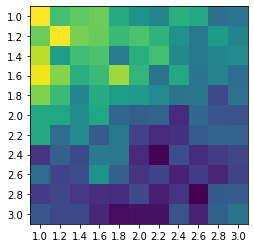

In [8]:
fig, ax = plt.subplots()
ax.imshow(img)
ax.set_yticks(range(len(exposure_durations)))
ax.set_yticklabels(exposure_durations)
ax.set_xticks(range(len(times_until_symtoms)))
ax.set_xticklabels(times_until_symtoms);

In [9]:
idx_best = results["diff"].idxmin()
best_e_mean = results.loc[idx_best, "e_mean"]
best_e_std = results.loc[idx_best, "e_std"]
best_t_mean = results.loc[idx_best, "t_mean"]
best_t_std = results.loc[idx_best, "t_std"]
best_i_mean = results.loc[idx_best, "i_mean"]
best_i_std = results.loc[idx_best, "i_std"]

print(f"best e: [{best_e_mean, best_e_std}]")
print(f"best t: [{best_t_mean, best_t_std}]")
print(f"best i: [{best_i_mean, best_i_std}]")

best e: [(3.0, 2.5)]
best t: [(2.2, 2.0)]
best i: [(10.6, 4.0)]


In [10]:
results[results["diff"] < 0.6]

,e_mean,t_mean,i_mean,e_std,t_std,i_std,true_e_mean,true_e_std,true_t_mean,true_t_std,...,true_i_std,e_mean_diff,e_std_diff,t_mean_diff,t_std_diff,i_mean_diff,i_std_diff,mean_diff,std_diff,diff
153821,3.0,1.2,10.8,2.25,2.00,4.0,1.844,1.244855,3.039,2.235951,...,3.821115,0.024336,0.429215,0.001521,0.112863,0.006561,0.016611,0.032418,0.558690,0.591108
156614,3.0,1.6,10.8,2.50,2.00,4.0,1.805,1.189527,2.992,2.073629,...,3.874239,0.038025,0.504772,0.000064,0.030147,0.007056,0.005740,0.045145,0.540658,0.585803
157967,3.0,1.8,10.8,2.25,2.00,4.0,1.862,1.199565,3.181,2.085723,...,3.974665,0.019044,0.490609,0.032761,0.034493,0.000361,0.000608,0.052166,0.525711,0.577877
160608,3.0,2.2,10.6,2.50,2.00,4.0,1.921,1.234811,3.247,1.931836,...,3.768070,0.006241,0.442476,0.061009,0.001014,0.004489,0.033099,0.071739,0.476588,0.548327
160699,3.0,2.2,10.8,2.25,1.75,4.0,1.898,1.196493,3.197,1.791142,...,3.898593,0.010404,0.494922,0.038809,0.011850,0.000729,0.002643,0.049942,0.509414,0.559356


### Fine grid search

In [22]:
step = 0.05
window = 0.25
exposure_durations = np.arange(best_e_mean - window, best_e_mean + window + step, step)
times_until_symtoms = np.arange(best_t_mean - window, best_t_mean + window + step, step)
infection_durations = np.arange(best_i_mean - window, best_i_mean + window + step, step)

step = 0.1
exposure_duration_stds = np.arange(best_e_std - window, best_e_std + window + step, step)
times_until_symtoms_stds = np.arange(best_t_std - window, best_t_std + window + step, step)
infection_durations_stds = np.arange(best_i_std - window, best_i_std + window + step, step)

param_combinations = [(e, t, i, e_std, t_std, i_std) \
                                for e in exposure_durations \
                                for t in times_until_symtoms \
                                for i in infection_durations \
                                for e_std in exposure_duration_stds \
                                for t_std in times_until_symtoms_stds \
                                for i_std in infection_durations_stds]
print(f"{len(param_combinations)} parameter combinations")

426888 parameter combinations


In [12]:
results_fine = pd.DataFrame()

pool = Pool(200)
for row in tqdm(
        pool.imap_unordered(
            func=get_true_epi_params, 
            iterable=param_combinations),
            total=len(param_combinations)
    ):
    results_fine = results_fine.append(row, ignore_index=True)
pool.close()

100%|███████████████████████████████████████████████████████████████████████████| 426888/426888 [41:06<00:00, 173.04it/s]


In [14]:
results_fine["e_mean_diff"] = results_fine["true_e_mean"]\
    .apply(lambda x: (x - expected_epi_params["exposure_duration"]["mean"]) ** 2)
results_fine["e_std_diff"] = results_fine["true_e_std"]\
    .apply(lambda x: (x - expected_epi_params["exposure_duration"]["std"]) ** 2)
results_fine["t_mean_diff"] = results_fine["true_t_mean"]\
    .apply(lambda x: (x - expected_epi_params["time_until_symptoms"]["mean"]) ** 2)
results_fine["t_std_diff"] = results_fine["true_t_std"]\
    .apply(lambda x: (x - expected_epi_params["time_until_symptoms"]["std"]) ** 2)
results_fine["i_mean_diff"] = results_fine["true_i_mean"]\
    .apply(lambda x: (x - expected_epi_params["infection_duration"]["mean"]) ** 2)
results_fine["i_std_diff"] = results_fine["true_i_std"]\
    .apply(lambda x: (x - expected_epi_params["infection_duration"]["std"]) ** 2)

results_fine["mean_diff"] = results_fine["e_mean_diff"] + results_fine["t_mean_diff"] + results_fine["i_mean_diff"]
results_fine["std_diff"] = results_fine["e_std_diff"] + results_fine["t_std_diff"] + results_fine["i_std_diff"]
results_fine["diff"] = results_fine["mean_diff"] + results_fine["std_diff"]

results_fine.to_csv("results_fine.csv", index=False)

In [39]:
results_fine = results_fine.reset_index()

In [40]:
exposure_durations = [round(e, 3) for e in exposure_durations]
times_until_symtoms = [round(t, 3) for t in times_until_symtoms]

round_cols = ["e_mean", "e_std", "t_mean", "t_std", "i_mean", "i_std"]
for col in round_cols:
    results_fine[col] = results_fine[col].apply(lambda x: round(x, 3))
    
img = np.zeros((len(exposure_durations), len(times_until_symtoms)))

results_fine = results_fine.set_index(["e_mean", "t_mean", "i_mean", "e_std", "t_std", "i_std"])
for i, e in enumerate(exposure_durations):
    for j, t in enumerate(times_until_symtoms):
        img[i, j] = results_fine.loc[e, t, 10.6, 2.65, 1.85, 3.75]["diff"]
results_fine = results_fine.reset_index()

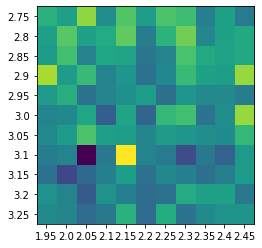

In [41]:
fig, ax = plt.subplots()
ax.imshow(img)
ax.set_yticks(range(len(exposure_durations)))
ax.set_yticklabels(exposure_durations)
ax.set_xticks(range(len(times_until_symtoms)))
ax.set_xticklabels(times_until_symtoms);

In [42]:
idx_best = results_fine["diff"].idxmin()
best_e_mean = results_fine.loc[idx_best, "e_mean"]
best_e_std = results_fine.loc[idx_best, "e_std"]
best_t_mean = results_fine.loc[idx_best, "t_mean"]
best_t_std = results_fine.loc[idx_best, "t_std"]
best_i_mean = results_fine.loc[idx_best, "i_mean"]
best_i_std = results_fine.loc[idx_best, "i_std"]

true_e_mean = results_fine.loc[idx_best, "true_e_mean"]
true_e_std = results_fine.loc[idx_best, "true_e_std"]
true_t_mean = results_fine.loc[idx_best, "true_t_mean"]
true_t_std = results_fine.loc[idx_best, "true_t_std"]
true_i_mean = results_fine.loc[idx_best, "true_i_mean"]
true_i_std = results_fine.loc[idx_best, "true_i_std"]

print(f"best e: [{best_e_mean, best_e_std}]")
print(f"best t: [{best_t_mean, best_t_std}]")
print(f"best i: [{best_i_mean, best_i_std}]")
print()
print(f"true e: [{true_e_mean, true_e_std}]")
print(f"true t: [{true_t_mean, true_t_std}]")
print(f"true i: [{true_i_mean, true_i_std}]")

best e: [(3.1, 2.65)]
best t: [(2.05, 1.85)]
best i: [(10.6, 3.75)]

true e: [(1.89, 1.2906974858579372)]
true t: [(3.147, 1.9691091894559836)]
true i: [(10.935, 3.754300867005733)]


### Epi parameter distribution plot

In [44]:
curr_epi_params = {
        "exposure_duration":{"mean":best_e_mean, "std":best_e_std},
        "time_until_symptoms":{"mean":best_t_mean, "std":best_t_std},
        "infection_duration":{"mean":best_i_mean, "std":best_i_std}
    }
for param_name in curr_epi_params.keys():
    mu = curr_epi_params[param_name]["mean"]
    var = curr_epi_params[param_name]["std"]**2
    shape = root_scalar(get_weibull_shape, args=(mu, var),
                method='toms748', bracket=[0.2, 500]).root
    scale = get_weibull_scale(mu, shape)
    curr_epi_params[param_name]["shape"] = shape
    curr_epi_params[param_name]["scale"] = scale

exposure_duration = []
time_until_symptoms = []
infection_duration = []
for i in range(10000):
    tmp_epi_params = {}
    while True:
        for param_name in curr_epi_params.keys():
            tmp_epi_params[param_name] = \
                round(weibull_two_param(curr_epi_params[param_name]["shape"],
                                        curr_epi_params[param_name]["scale"]))

        if (tmp_epi_params['exposure_duration'] >= 1) and \
           (tmp_epi_params['time_until_symptoms'] >= \
           tmp_epi_params['exposure_duration']) and\
           (tmp_epi_params['infection_duration'] >= \
           tmp_epi_params['time_until_symptoms']):
           break

    exposure_duration.append(tmp_epi_params['exposure_duration'])
    time_until_symptoms.append(tmp_epi_params['time_until_symptoms'])
    infection_duration.append(tmp_epi_params['infection_duration'])

exposure_duration = np.asarray(exposure_duration)
time_until_symptoms = np.asarray(time_until_symptoms)
infection_duration = np.asarray(infection_duration)

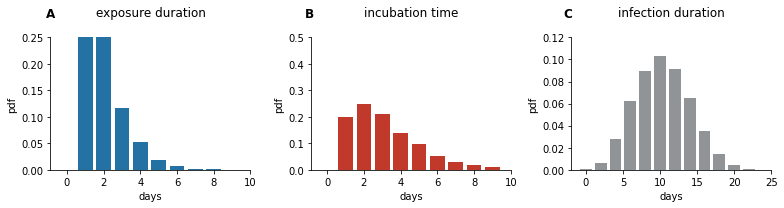

In [46]:
fig, axes = plt.subplots(1, 3, figsize=(11, 3))
fig.subplots_adjust(wspace=0.3)
max_bins = [11, 11, 26]
steps = [1, 1, 2]
colors = ['#2471A3', '#C0392B', '#909497']
xticks = [range(0, 11, 2), range(0, 11, 2), range(0, 26, 5)]
labels = ['exposure duration\n', 'incubation time\n', 'infection duration\n']
ymaxes = [0.25, 0.5, 0.12]

for ax, max_bin, step, color, xtick, label, ymax, param in zip(axes, max_bins, steps, colors,\
    xticks, labels, ymaxes, [exposure_duration, time_until_symptoms, infection_duration]):
    ax.hist(param, bins=range(0, max_bin, step), rwidth=0.8, color=color,
            density=True, align='left')
    ax.set_xticks(xtick)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title(label)
    ax.set_ylabel('pdf')
    ax.set_xlabel('days')
    ax.set_ylim(0, ymax)

fig.tight_layout()
fig.text(0.062, 0.9, 'A', fontsize=12, fontweight='bold')
fig.text(0.39, 0.9, 'B', fontsize=12, fontweight='bold')
fig.text(0.7162, 0.9, 'C', fontsize=12, fontweight='bold')